### Lars Folkestad
# Assignment 1: Backpropagation with numpy
# 1. Setup
## 1.0 Import necessary packages

In [1]:
import numpy as np
from configparser import ConfigParser
import matplotlib.pyplot as plt
#import enum
from scipy import special
#np.set_printoptions(threshold=5)

## 1.1 Config file
### 1.0.0 Parse config file

In [2]:
def parse_config(file_path):
    
    #Initialize parser
    parser = ConfigParser()

    #Read config file
    parser.read(file_path)

    #Extract data from config file
    training_path = parser['DATA']['training']
    validation_path = parser['DATA']['validation']
    layers = parser['MODEL']['layers']
    activations = parser['MODEL']['activations']
    loss_type = parser['MODEL']['loss_type']
    learning_rate = parser['HYPER']['learning_rate']
    no_epochs = parser['HYPER']['no_epochs']
    L2_regularization = parser['HYPER']['L2_regularization']
    
    #Return dictionary with all raw data
    return {
        'training_path': training_path,
        'validation_path': validation_path,
        'layers': layers,
        'activations': activations,
        'loss_type': loss_type,
        'learning_rate': learning_rate, 
        'no_epochs': no_epochs,
        'L2_regularization': L2_regularization
    }

### 1.0.1 Config file components explained

* **Training path:** The training path is a pointer to the file containing data used to fit the model (train). 
* **Validation path:** The validation path is a pointer to the file containing data used to evaluate the model during training, i.e. see how well it performs. 
* **Layers:** Each layer consists of neurons with the same type of activation function. The first and last layer is referred to as the input- and output layer, whereas the rest are referred to as hidden layers. 
* **Activations:** Activation functions of a neuron defines the output given a set of inputs, i.e. the functions are "activated" depending on the input. The greater the value of the output, the more more activated the neuron is. 
    * The linear function is defined as $f(x) = x$ with range $(-\infty,\infty)$
    * TanH is defined as f(x) = $\frac{e^x-e^{-x}}{e^x+e^{-x}}$ with range $(-1,1)$
    * ReLU (rectified linear unit) is defined as $f(x) = \max(0,x)$ with range $[0,\infty)$
* **Loss type:** Describes wether to use L2 loss (for regression) and cross_entropy (for classification)
    * L2 loss (least square errors) minimizes the squared differences between the estimated and existing target values
    * Cross-entropy loss (log loss) measures the performance of a classification model with a probability output value between 0 and 1
* **Learning rate:** The learning rate decides the step-size of the updated parameters in the gradient descent optimization algorithm. With a high learning rate, we risk overshooting the optimal solution. On the other hand, a low learning rate is more precise but can make calculating the gradient very time-consuming.
* **Epoch:** The number of epochs describe the number of times the algorithm sees the entire data set
* **L2 regularization:** L2 regularization (ridge regression) is a loss function with squared L2 norm of the weights. The regularization term is a added constraint by which the optimization algorithm is subject to when minimizing the loss function in order to avoid overfitting.

### 1.0.2 Format input from config file

In [3]:
def get_params_config(file_path):
    
    # Get raw strings from config file
    config = parse_config(file_path)
    
    #### Layers
    #Re-format the layers_config-string to a list of integers without whitespaces or commas.
    #This also works with the special case when layers = 0.
    layers = config['layers']
    layers = layers.split(',')
    #Empty list for layers = 0
    layers = [int(i.strip(' ')) for i in layers]
    config['layers'] = layers
    
    
    #### Activations
    #Re-format the activations_config-string to a list of strings without whitespaces or commas.
    activations = config['activations']
    activations = activations.split(',')
    activations = [i.strip(' ') for i in activations if i]
    config['activations'] = activations
    
    #### Learning rate
    #Re-format the learning_rate_config-string to a float
    learning_rate = float(config['learning_rate'])
    config['learning_rate'] = learning_rate
    
    #### Epochs
    #Re-format the no_epochs_config-string to an integer
    no_epochs = int(config['no_epochs'])
    config['no_epochs'] = no_epochs
                    
    #### L2 regularization
    #Re-format the L2_regularization-string to a float
    L2_regularization = float(config['L2_regularization'])
    config['L2_regularization'] = L2_regularization
    
    return config

## 1.2 Data files

### 1.2.0 Format data

In [4]:
def get_data(data_set, config):
    try:
        #Reads data and writes to a 2D numpy array with float64 values
        path = config[data_set+'_path']
        data = np.genfromtxt(path, delimiter=',')

        #Split training data into x (examples) and y (classes). The classes in y are converted to int. 
        x = data[:,:-1].T
        y = data[:,-1].astype(int)
        y = y.reshape((len(y),1)).T

        return {
            'x': x,
            'y': y,
        }
    except KeyError:
        raise KeyError("Input must be one of the following: ['training','validation']")
        
    except:
        raise

In [5]:
def one_hot_encode(x,y):    
    
    #Define variables
    no_classes = 1 + y.max()
    no_examples = x.shape[1]
    
    #Transform data to one-hot encoding
    one_hot = np.zeros((no_examples, no_classes)).astype('int')
    one_hot[np.arange(no_examples),y] = 1
    
    return one_hot

## 1.3 Activation Functions and Derivatives

### 1.3.0 ReLU

In [6]:
def relu(z):
    a = np.maximum(0,z)
    assert(a.shape==z.shape)
    
    return a

def relu_prime(z):
    dz = np.where(z <= 0, 0, 1)
    assert(dz.shape==z.shape)
    
    return dz

### 1.3.1 Softmax
Softmax is used for multiclass classification. The function returns for every example a classwise probability of being a member of that class.

In [7]:
def softmax(z):
    e_z = np.exp(z - np.max(z))
    a = e_z / e_z.sum(axis=0)
    assert(a.shape==z.shape) 
    
    return a

def softmax_prime(z):
    dz = np.diag(softmax(z))
    assert(dz.shape==z)
    
    return dz

### 1.3.2 Linear

In [8]:
def linear(z):
    return z

def linear_prime(z):
    return 1

### 1.3.3 Tanh

In [9]:
def tanh(z):    
    a = np.tanh(z)
    assert(a.shape==z.shape)

    return a

def tanh_prime(z):
    dz = -np.square(tanh(z)) + 1
    assert(dz.shape==z.shape)

    return dz

### 1.3.4 General activation function

In [10]:
def activation_function(z,activation):
    if (activation == 'relu'):
        return relu(z)
    elif (activation == 'softmax'):
        return softmax(z)
    elif (activation == 'linear'):
        return linear(z)
    elif(activation == 'tanh'):
        return tanh(z)

### 1.3.5 General derivative of activation function

In [11]:
def derivative_activation_function(z,activation):
    if (activation == 'relu'):
        return relu_prime(z)
    elif (activation == 'softmax'):
        return softmax(z)
    elif (activation == 'linear'):
        return linear_prime(z)
    elif(activation == 'tanh'):
        return tanh_prime(z)

## 1.4 Loss Functions

### 1.4.1 L2 Loss
L2-norm loss: $L2 = \frac{1}{m} \sum^{m}_{i=1}{(y_i - f(x_i))^2} = \frac{1}{m}(Y-\hat{Y})^2$

In [12]:
def L2_loss(Y, Y_hat):
    m = Y_hat.shape[1]
    loss = np.dot(np.abs(Y-Y_hat),np.abs(Y-Y_hat).T)/m
    loss = loss.squeeze()
    return loss

def delta_L2_loss(Y,A):
    m = A.shape[1]
    dA = -(2/m)*(Y-A)
    return dA

### 1.4.2 Cross-Entropy Loss

In [13]:
def cross_entropy(y, p_hat):
    
    m = p_hat.shape[1]
    
    #Retrieve probability for choosing right class for every example
    likelihood = p_hat[y,range(m)]
    
    #Maximizing likelihood can be done by minimizing log likelihood
    log_likelihood = -np.log(likelihood)
    
    #The average cross-entropy error function
    loss = np.sum(log_likelihood) / m
    
    return loss

def delta_cross_entropy(y,p_hat):
    m = p_hat.shape[1]
    dA = p_hat - y
    dA = dA/m
    
    return dA

### 1.4.2 General loss function

In [14]:
def loss_function(Y,Y_hat,loss_type):
    if(loss_type == 'L2'):
        return L2_loss(Y,Y_hat)
    elif(loss_type == 'cross_entropy'):
        return cross_entropy(Y,Y_hat)
    
def delta_loss_function(Y,Y_hat,loss_type):
    if(loss_type == 'L2'):
        return delta_L2_loss(Y,Y_hat)
    elif(loss_type == 'cross_entropy'):
        return delta_cross_entropy(Y,Y_hat)

## 1.5 Initialize parameters

In [15]:
def initialize(X,Y,config):
    
    #Generate the same pseudo-random integers for each random function
    np.random.seed(42)
    
    #Retrieve necessary parameters from config 
    layers = config['layers']
    loss_type = config['loss_type']
    activations = config['activations']
    input_dim = X.shape[0]
    output_dim = 0
    
    #Set output dimension depending on regression or classification
    
    #Regression
    if(loss_type == 'L2'):  
        activations.append('relu')
        output_dim = Y.shape[0]
    #Classification
    elif(loss_type == 'cross_entropy'):
        activations.append('softmax')
        output_dim = one_hot_encode(X,Y).shape[1]
    
    #No hidden layer
    if(layers[0] == 0):
        layers =  [input_dim]+[output_dim]
    
    #Hidden layers
    else: 
        layers = [input_dim] + layers + [output_dim]
    
    w = [np.random.randn(x, y) for x, y in zip(layers[:-1], layers[1:])]
    b = [np.random.randn(y, 1) for y in layers[1:]]
    
    return w, b, activations

## 1.6 Gradient Descent

### 1.6.0 Forward propagation

In [16]:
def forward_propagate(weights,biases,X,activations):
    Z = []
    A = [X]
    i = 0

    for w,b in zip(weights,biases):
        z = np.dot(w.T,A[i]) + b
        Z.append(z)
        A.append(activation_function(z,activations[i]))
        i+=1
    return Z,A

### 1.6.1 Backward propagation

In [17]:
def linear_backward(dz,A):
    m = A.shape[1]
    dw = (1/m)*(np.dot(dz,A.T)).T
    db = (1/m)*(np.sum(dz,axis = 1,keepdims = True))
    
    return dw, db

In [18]:
def backward_propagate(w,b,Z,A,Y,loss_type,activations):
    dws, dbs = [],[]
    
    #Initialize for last layer
    if(loss_type == 'cross_entropy'):
        Y = one_hot_encode(A[0],Y).T
    
    dL = delta_loss_function(Y,A[-1],loss_type)
    dz = np.multiply(dL,derivative_activation_function(Z[-1],activations[-1]))

    dw , db = linear_backward(dz,A[-2])
    dws = [dw] + dws
    dbs = [db] + dbs
      
    #Loop through hidden layers
    for i in range(len(A)-3,-1,-1):
        dz = np.multiply(np.dot(w[i+1],dz),derivative_activation_function(Z[i],activations[i]))
        dw , db = linear_backward(dz,A[i])         
        dws = [dw] + dws
        dbs = [db] + dbs
    
    
    for i in range(len(dbs)):
        assert(dws[i].shape == w[i].shape)
        assert(dbs[i].shape == b[i].shape)
    
    return dws,dbs

### 1.6.2 Gradient descent

In [19]:
def gradient_descent(w, b, X_train, Y_train, X_validate, Y_validate, no_epochs, learning_rate,activations,loss_type):    
    
    #List of loss for training and validation data for each iteration for plotting
    costs = {'training':[], 'validation':[]}
    
    #Perform gradient descent for no. of iterations specified by no_epochs
    for i in range(no_epochs):
        Z_train,A_train = forward_propagate(w,b,X_train,activations)
        Z_val,A_val =  forward_propagate(w,b,X_validate,activations)
        
        #Calculate loss
        loss_train = loss_function(Y_train,A_train[-1],loss_type)
        loss_val = loss_function(Y_validate,A_val[-1],loss_type)
        
        #Add loss to cost-list
        costs['training'].append(loss_train)
        costs['validation'].append(loss_val)
        
        #Dump loss to console
        
        #Print every result for minimal regression and minimal classification
        if(len(activations) ==1):
            #print("Epoch: (loss on training data, loss on validation data")
            print("E: {0}\nT: {1}\nV: {2})\n".format(i,loss_train,loss_val))
            
        #Print every 50th result for models with hidden layers
        elif(i==0 or (i+1)%50==0):
            print("Epoch: {}".format(i))
            print("Loss on training data: {}".format(loss_train))
            print("Loss on validation data: {}".format(loss_val))
            print()

        
        #Calculate gradient with backpropagation, and perform gradient descent
        dw, db = backward_propagate(w,b,Z_train,A_train,Y_train,loss_type,activations)
        
        #Gradient descent
        for i in range(len(dw)):    
            w[i] -= learning_rate*dw[i]
            b[i] -= learning_rate*db[i]   
    
    parameters = {"w": w, "b": b}
    gradient = {"dw": dw, "db": db}
    
    return parameters, gradient, costs

## 1.7 Classification accuracy

In [20]:
def classification_accuracy(w,b,X,Y,activations):
    
    #Predicted values
    Y_hat = forward_propagate(w,b,X,activations)[-1][1]
    correct=0
    wrong=0
    for i in range(Y_hat.shape[1]):
        #Find index of class with highest predicted probability
        #and check if that corresponds to the correct class 
        if(np.where(Y_hat[:,i]==max(Y_hat[:,i]))[0] == Y[0,i]):
            correct += 1
        else:
            wrong += 1
    
    accuracy = (correct/(correct+wrong))*100

    return correct, wrong, accuracy

In [21]:
def print_results(w,b,X,Y,activations):
    correct, wrong, accuracy = classification_accuracy(w,b,X,Y,activations)
    print("Correctly classified: {}".format(correct))
    print("Wrongly classified: {}".format(wrong))
    print("Accuracy: {0:.3g}%".format(accuracy))

## 1.8 Model

### 1.8.0 Model

In [22]:
def model(config, modelname):
    
    training_data = get_data('training',config)
    validation_data = get_data('validation',config)
    
    X_train = training_data['x']
    Y_train = training_data['y']
    X_validate = validation_data['x']
    Y_validate = validation_data['y']
    no_epochs = config['no_epochs']
    learning_rate = config['learning_rate']
    loss_type = config['loss_type']    
    
    print("\n{}\n".format(modelname))
    
    #Initialize weights and biases
    w,b,activations = initialize(X_train, Y_train,config)
    print(activations)
    
    #Run model
    parameters, gradient, costs = gradient_descent(w, b, X_train, Y_train,
                                                   X_validate, Y_validate, 
                                                   no_epochs, learning_rate, activations,loss_type)
    
    #Dump learned weights and biases to text file if no hidden layer
    if(len(activations) ==1):
        np.savetxt('./weights/weights_{}.txt'.format(modelname), parameters['w'][0])
        np.savetxt('./weights/biases_{}.txt'.format(modelname), parameters['b'][0])
    
    #Cost
    training_cost = np.array(costs['training'])
    validation_cost = np.array(costs['validation'])
    
    
    #Plot cost development on training and cost data
    fig = plt.figure()
    ax = plt.subplot()
    y1 = training_cost
    y2 = validation_cost
    ax.plot(y1, label='Training data')
    ax.plot(y2, label='Validation data')
    ax.legend()
    plt.title('Cost per Epoch')
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.show()
    
    if(loss_type=='cross_entropy'):
        #Print classification results
        w,b = parameters['w'], parameters['b']
        print("Training data results:\n")
        print_results(w,b,X_train,Y_train,activations)

        print("\nValidation data results\n")
        print_results(w,b,X_validate,Y_validate,activations)

### 1.8.1 Run model

In [23]:
def run_model(modelname):
    config = get_params_config('./config/config_{}.txt'.format(modelname))
    for k,v in config.items():
        print(k,": ",v)
    model(config,modelname)

# 2. Models
## 2.1 Minimalist example for regression

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [0]
activations :  []
loss_type :  L2
learning_rate :  50.0
no_epochs :  500
L2_regularization :  0.005

minimal_regression

['relu']
E: 0
T: 40.47852882699442
V: 40.918693211247245)

E: 1
T: 33.592931209103625
V: 32.83829060954286)

E: 2
T: 31.195611997486107
V: 29.804939054326855)

E: 3
T: 29.966432148918322
V: 28.23907449226044)

E: 4
T: 29.224230864057855
V: 27.305913281770362)

E: 5
T: 28.731945711030217
V: 26.684787529452063)

E: 6
T: 28.370119313849518
V: 26.23541366399762)

E: 7
T: 28.065809913208426
V: 25.869683009920294)

E: 8
T: 27.79648351058561
V: 25.55058688590272)

E: 9
T: 27.532408872822035
V: 25.257315453248143)

E: 10
T: 27.258825730176927
V: 24.962819044970836)

E: 11
T: 26.980459271707325
V: 24.658485823565076)

E: 12
T: 26.675068855177006
V: 24.33128597234776)

E: 13
T: 26.34314483948865
V: 24.00685729750343)

E: 14
T: 25.97807138186114
V: 23.656940678530255)

E: 15
T: 25

E: 155
T: 10.863092885186653
V: 11.117086727481107)

E: 156
T: 10.839248615549524
V: 11.093581204155738)

E: 157
T: 10.81513220846498
V: 11.076020562422716)

E: 158
T: 10.791532630821555
V: 11.051138921150415)

E: 159
T: 10.768241779009488
V: 11.030326230269644)

E: 160
T: 10.74481714921325
V: 11.01435010636722)

E: 161
T: 10.721775363484001
V: 10.992684207197696)

E: 162
T: 10.698782746731744
V: 10.971003812113718)

E: 163
T: 10.676046548748607
V: 10.95142017545765)

E: 164
T: 10.653649875721639
V: 10.929535038910554)

E: 165
T: 10.631641784848679
V: 10.907785385341185)

E: 166
T: 10.60993957983186
V: 10.886067885474157)

E: 167
T: 10.588458447748286
V: 10.865046226015489)

E: 168
T: 10.567147135030494
V: 10.84458267605221)

E: 169
T: 10.546034092760847
V: 10.824216443651265)

E: 170
T: 10.52511706166682
V: 10.806258067062696)

E: 171
T: 10.50454347195534
V: 10.783788019194334)

E: 172
T: 10.48415829592859
V: 10.76290606709947)

E: 173
T: 10.463592693740946
V: 10.74600214276271)

E: 1

E: 319
T: 7.9425560037686305
V: 8.416390323357339)

E: 320
T: 7.928197568286085
V: 8.402800110786702)

E: 321
T: 7.9139159349260755
V: 8.39081256455138)

E: 322
T: 7.899449419710635
V: 8.379856481320111)

E: 323
T: 7.884775615818065
V: 8.368388443510131)

E: 324
T: 7.869272918604311
V: 8.358745062241303)

E: 325
T: 7.852593490027499
V: 8.35885086153958)

E: 326
T: 7.836255319874574
V: 8.346164299882261)

E: 327
T: 7.820041128405453
V: 8.333684822299311)

E: 328
T: 7.803992618458338
V: 8.3201038687184)

E: 329
T: 7.788289664210393
V: 8.305003494935955)

E: 330
T: 7.772705946276273
V: 8.291651285873332)

E: 331
T: 7.757189073378093
V: 8.278360739186766)

E: 332
T: 7.741465525359425
V: 8.26497942059809)

E: 333
T: 7.725713700045102
V: 8.251173561869175)

E: 334
T: 7.710166671741101
V: 8.235040492670324)

E: 335
T: 7.694850269719309
V: 8.21983742395331)

E: 336
T: 7.679432197272902
V: 8.20770403505909)

E: 337
T: 7.663964956669423
V: 8.194997668013652)

E: 338
T: 7.64876157375898
V: 8.1787

E: 480
T: 6.0276436687082215
V: 6.809052570098271)

E: 481
T: 6.019198136150125
V: 6.801322187109576)

E: 482
T: 6.010744696254875
V: 6.795794803850123)

E: 483
T: 6.002372663981037
V: 6.787431351557494)

E: 484
T: 5.994078487353304
V: 6.781256017559014)

E: 485
T: 5.985859286620851
V: 6.773722758746758)

E: 486
T: 5.977709708113058
V: 6.767286554411468)

E: 487
T: 5.9696280705333855
V: 6.760479193878071)

E: 488
T: 5.961615431142303
V: 6.753699868153886)

E: 489
T: 5.953670005209746
V: 6.74702812066339)

E: 490
T: 5.9457901098323
V: 6.7404075000581525)

E: 491
T: 5.937974272092633
V: 6.733845307136392)

E: 492
T: 5.930203378328565
V: 6.727337159646684)

E: 493
T: 5.922406136899531
V: 6.7226682885647255)

E: 494
T: 5.914676707368857
V: 6.714866012173181)

E: 495
T: 5.90696767497324
V: 6.71022260624181)

E: 496
T: 5.899306009286448
V: 6.702341869091468)

E: 497
T: 5.891426931276255
V: 6.700067590568036)

E: 498
T: 5.883634080113041
V: 6.694482709979331)

E: 499
T: 5.875914921990189
V: 6

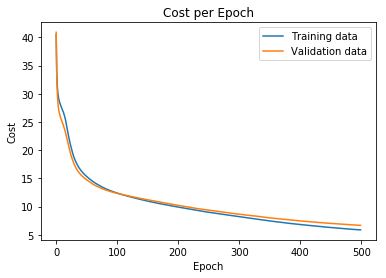

In [24]:
run_model('minimal_regression')

## 2.2 Minimalist example for classification

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [0]
activations :  []
loss_type :  cross_entropy
learning_rate :  5000.0
no_epochs :  500
L2_regularization :  0.005

minimal_classification

['softmax']
E: 0
T: 15.857152542354237
V: 15.000374481613003)

E: 1
T: 14.611770075062395
V: 13.732687469799927)

E: 2
T: 12.393070846153128
V: 11.652408201250214)

E: 3
T: 11.474187030628958
V: 11.042589699210348)

E: 4
T: 10.528328252724346
V: 10.12578813983841)

E: 5
T: 10.011725460882525
V: 9.682048890300127)

E: 6
T: 9.294144835160562
V: 9.040651839424292)

E: 7
T: 8.938174335979882
V: 8.711520289040688)

E: 8
T: 8.470545727161703
V: 8.268357501238347)

E: 9
T: 8.43448036507348
V: 8.175272389404263)

E: 10
T: 7.836918647115381
V: 7.7327321478978925)

E: 11
T: 7.901662683794637
V: 7.681399705291614)

E: 12
T: 6.9063926903856165
V: 6.852630594284042)

E: 13
T: 6.749362504200926
V: 6.668786806755117)

E: 14
T: 6.616475200167331
V: 6.582095286501526)



E: 159
T: 0.8544571274871083
V: 1.2822426508486868)

E: 160
T: 0.8498005663103145
V: 1.278214825184888)

E: 161
T: 0.8451932974251686
V: 1.2742281601469305)

E: 162
T: 0.8406345078078886
V: 1.270281868176819)

E: 163
T: 0.8361234165381859
V: 1.2663751909351755)

E: 164
T: 0.831659273535179
V: 1.262507399248013)

E: 165
T: 0.8272413581741599
V: 1.2586777928883641)

E: 166
T: 0.8228689777977684
V: 1.2548857001820037)

E: 167
T: 0.8185414661521677
V: 1.251130477475535)

E: 168
T: 0.8142581817764085
V: 1.247411508485445)

E: 169
T: 0.8100185063789144
V: 1.2437282035657422)

E: 170
T: 0.8058218432317783
V: 1.2400799989229017)

E: 171
T: 0.8016676156124385
V: 1.2364663558114406)

E: 172
T: 0.7975552653173523
V: 1.2328867597369504)

E: 173
T: 0.7934842512680186
V: 1.2293407196915618)

E: 174
T: 0.7894540482245461
V: 1.2258277674412894)

E: 175
T: 0.785464145617635
V: 1.2223474568808974)

E: 176
T: 0.7815140465062188
V: 1.2188993634680234)

E: 177
T: 0.7776032666652093
V: 1.2154830837449158)



E: 318
T: 0.46874706132997074
V: 0.9656173094445019)

E: 319
T: 0.4675717943698387
V: 0.9649108357558941)

E: 320
T: 0.4664048596851002
V: 0.9642127204874295)

E: 321
T: 0.46524616457366924
V: 0.9635228573309855)

E: 322
T: 0.46409561721886117
V: 0.9628411418074723)

E: 323
T: 0.4629531266688765
V: 0.9621674712569229)

E: 324
T: 0.46181860281858145
V: 0.9615017448260751)

E: 325
T: 0.46069195639367677
V: 0.9608438634536977)

E: 326
T: 0.4595730989373947
V: 0.960193729854027)

E: 327
T: 0.4584619427997206
V: 0.9595512484984807)

E: 328
T: 0.4573584011291629
V: 0.958916325595958)

E: 329
T: 0.45626238786701706
V: 0.9582888690718692)

E: 330
T: 0.45517381774406324
V: 0.957668788546113)

E: 331
T: 0.4540926062795755
V: 0.9570559953101342)

E: 332
T: 0.4530186697825486
V: 0.9564504023032225)

E: 333
T: 0.4519519253549736
V: 0.9558519240881751)

E: 334
T: 0.4508922908970172
V: 0.9552604768264252)

E: 335
T: 0.4498396851139314
V: 0.9546759782527638)

E: 336
T: 0.4487940275245146
V: 0.95409834

E: 474
T: 0.3490255246962399
V: 0.9184794991961651)

E: 475
T: 0.34853800812562286
V: 0.9184331592777931)

E: 476
T: 0.3480531357787438
V: 0.918388633381254)

E: 477
T: 0.3475708938385778
V: 0.9183458996421443)

E: 478
T: 0.3470912683982755
V: 0.9183049363419936)

E: 479
T: 0.3466142454633845
V: 0.9182657219139396)

E: 480
T: 0.3461398109546694
V: 0.9182282349485084)

E: 481
T: 0.3456679507114776
V: 0.9181924541993993)

E: 482
T: 0.34519865049562537
V: 0.9181583585892991)

E: 483
T: 0.344731895995796
V: 0.9181259272156528)

E: 484
T: 0.34426767283238663
V: 0.9180951393563751)

E: 485
T: 0.34380596656278556
V: 0.918065974475504)

E: 486
T: 0.3433467626870393
V: 0.9180384122287422)

E: 487
T: 0.34289004665386413
V: 0.9180124324689188)

E: 488
T: 0.34243580386696465
V: 0.9179880152513308)

E: 489
T: 0.34198401969161407
V: 0.9179651408389811)

E: 490
T: 0.34153467946145816
V: 0.917943789707724)

E: 491
T: 0.34108776848547817
V: 0.9179239425512951)

E: 492
T: 0.3406432720551049
V: 0.9179055

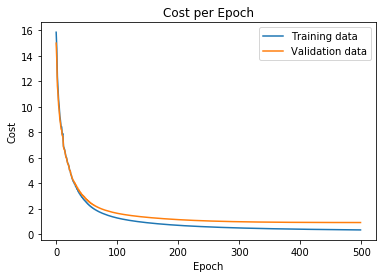

Training data results:

Correctly classified: 1868
Wrongly classified: 132
Accuracy: 93.4%

Validation data results

Correctly classified: 1619
Wrongly classified: 381
Accuracy: 81%


In [25]:
run_model('minimal_classification')

## 2.3 Single hidden layer regression

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [16]
activations :  ['relu']
loss_type :  L2
learning_rate :  50.0
no_epochs :  500
L2_regularization :  0.005

single_hidden_regression_relu

['relu', 'relu']
Epoch: 0
Loss on training data: 60.98894203894013
Loss on validation data: 64.35966511745042

Epoch: 49
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 99
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 149
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 199
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 249
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 299
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 349
Loss on training data: 29.265
Loss on validation data: 27.683744634422933

Epoch: 399
Loss on training data: 29.265
Loss on va

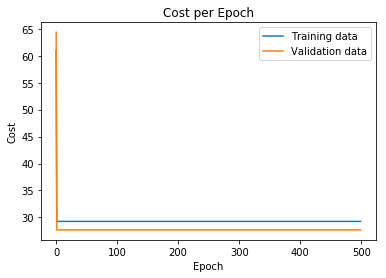

In [26]:
run_model('single_hidden_regression_relu')

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [16]
activations :  ['tanh']
loss_type :  L2
learning_rate :  5.0
no_epochs :  500
L2_regularization :  0.005

single_hidden_regression_tanh

['tanh', 'relu']
Epoch: 0
Loss on training data: 12.204660808081702
Loss on validation data: 10.58100809834599

Epoch: 49
Loss on training data: 10.704730626429829
Loss on validation data: 9.459966105178966

Epoch: 99
Loss on training data: 9.573190667333826
Loss on validation data: 8.67250475032751

Epoch: 149
Loss on training data: 8.724489379497427
Loss on validation data: 8.100335372538705

Epoch: 199
Loss on training data: 8.090790129664175
Loss on validation data: 7.664246514849694

Epoch: 249
Loss on training data: 7.643114732897435
Loss on validation data: 7.3451665982568635

Epoch: 299
Loss on training data: 7.311789203893728
Loss on validation data: 7.108515553491844

Epoch: 349
Loss on training data: 7.05964939890741
Loss on validation data: 

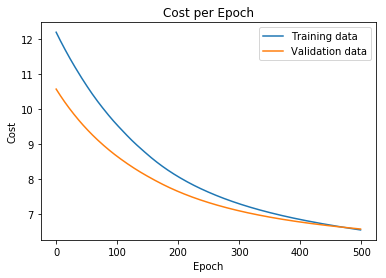

In [27]:
run_model('single_hidden_regression_tanh')

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [16]
activations :  ['linear']
loss_type :  L2
learning_rate :  0.5
no_epochs :  500
L2_regularization :  0.005

single_hidden_regression_linear

['linear', 'relu']
Epoch: 0
Loss on training data: 1195.7293871880308
Loss on validation data: 1384.6858476683624

Epoch: 49
Loss on training data: 33.636017698169745
Loss on validation data: 35.152383424681595

Epoch: 99
Loss on training data: 30.919249946191783
Loss on validation data: 31.045594385292574

Epoch: 149
Loss on training data: 30.16876677592775
Loss on validation data: 29.867427485297803

Epoch: 199
Loss on training data: 29.773775904306895
Loss on validation data: 29.208827074223816

Epoch: 249
Loss on training data: 29.574133494108857
Loss on validation data: 28.868075244432273

Epoch: 299
Loss on training data: 29.453720348741342
Loss on validation data: 28.672751513783034

Epoch: 349
Loss on training data: 29.373079243822307
Loss o

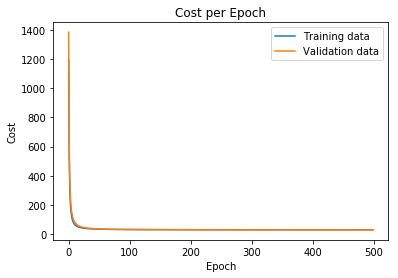

In [28]:
run_model('single_hidden_regression_linear')

## 2.4 Single hidden layer classification

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [16]
activations :  ['relu']
loss_type :  cross_entropy
learning_rate :  5.0
no_epochs :  700
L2_regularization :  0.005

single_hidden_classification

['relu', 'softmax']
Epoch: 0
Loss on training data: 37.396751462122424
Loss on validation data: 33.559666612046136

Epoch: 49
Loss on training data: 23.925980150208275
Loss on validation data: 21.71261154588622

Epoch: 99
Loss on training data: 19.82659721067601
Loss on validation data: 18.24625152785479

Epoch: 149
Loss on training data: 17.62311380205979
Loss on validation data: 16.373354312866276

Epoch: 199
Loss on training data: 16.107740390304844
Loss on validation data: 15.068486130665748

Epoch: 249
Loss on training data: 14.909010707796295
Loss on validation data: 14.007290132159138

Epoch: 299
Loss on training data: 13.892682961493978
Loss on validation data: 13.085675324385647

Epoch: 349
Loss on training data: 13.015873116820531
Lo

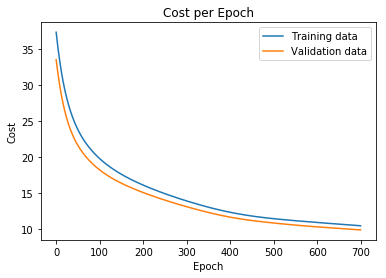

Training data results:

Correctly classified: 172
Wrongly classified: 1828
Accuracy: 8.6%

Validation data results

Correctly classified: 171
Wrongly classified: 1829
Accuracy: 8.55%


In [29]:
run_model('single_hidden_classification')

## 2.5 Arbitrary hidden layers regression

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [32, 16]
activations :  ['relu', 'relu']
loss_type :  L2
learning_rate :  0.005
no_epochs :  1000
L2_regularization :  0.005

hidden_regression2

['relu', 'relu', 'relu']
Epoch: 0
Loss on training data: 17426.234535348085
Loss on validation data: 15497.828340276867

Epoch: 49
Loss on training data: 508.28964385342283
Loss on validation data: 553.6663466816117

Epoch: 99
Loss on training data: 193.1465477684713
Loss on validation data: 227.09693897143424

Epoch: 149
Loss on training data: 119.85909837579419
Loss on validation data: 143.8281363821201

Epoch: 199
Loss on training data: 90.68886583692961
Loss on validation data: 108.23762355210847

Epoch: 249
Loss on training data: 75.52883783425362
Loss on validation data: 88.70143490611585

Epoch: 299
Loss on training data: 66.1102377837589
Loss on validation data: 76.28421605615182

Epoch: 349
Loss on training data: 59.934606123403896
Loss on 

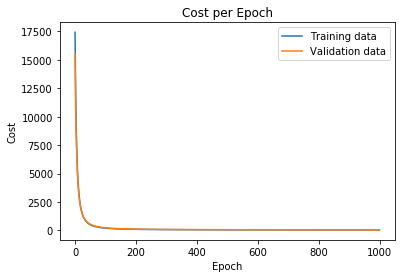

In [30]:
run_model('hidden_regression2')

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [32, 32, 16]
activations :  ['relu', 'tanh', 'relu']
loss_type :  L2
learning_rate :  0.05
no_epochs :  1000
L2_regularization :  0.005

hidden_regression3

['relu', 'tanh', 'relu', 'relu']
Epoch: 0
Loss on training data: 90.52301404350408
Loss on validation data: 85.0575842544959

Epoch: 49
Loss on training data: 62.07092874974663
Loss on validation data: 59.26341962200028

Epoch: 99
Loss on training data: 48.78625035584335
Loss on validation data: 47.22589988957951

Epoch: 149
Loss on training data: 42.237423279623094
Loss on validation data: 41.30946238142657

Epoch: 199
Loss on training data: 38.7099324179151
Loss on validation data: 38.165884807025414

Epoch: 249
Loss on training data: 36.46526344037609
Loss on validation data: 36.17074176609842

Epoch: 299
Loss on training data: 34.971721555305805
Loss on validation data: 34.83863503831518

Epoch: 349
Loss on training data: 33.822999297

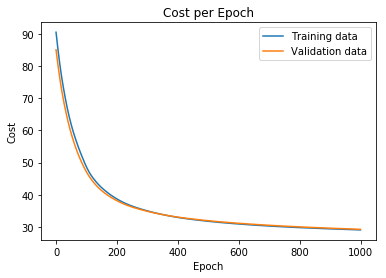

In [31]:
run_model('hidden_regression3')

## 2.6 Arbitrary hidden layers classification

training_path :  ./Data/train_small.csv
validation_path :  ./Data/validate_small.csv
layers :  [32, 32, 16]
activations :  ['relu', 'tanh', 'relu']
loss_type :  cross_entropy
learning_rate :  0.5
no_epochs :  500
L2_regularization :  0.005

hidden_classification1

['relu', 'tanh', 'relu', 'softmax']
Epoch: 0
Loss on training data: 19.70126810908487
Loss on validation data: 19.002616539148356

Epoch: 49
Loss on training data: 18.711241712462865
Loss on validation data: 18.07943579093586

Epoch: 99
Loss on training data: 17.797703925758903
Loss on validation data: 17.24245137231122

Epoch: 149
Loss on training data: 16.961822832375677
Loss on validation data: 16.49653317078192

Epoch: 199
Loss on training data: 16.209511791253803
Loss on validation data: 15.83239580748235

Epoch: 249
Loss on training data: 15.577063734623088
Loss on validation data: 15.236038815583893

Epoch: 299
Loss on training data: 15.009002513672534
Loss on validation data: 14.704604096592957

Epoch: 349
Loss on tra

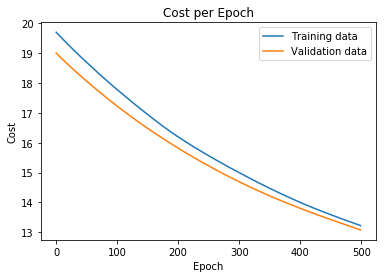

Training data results:

Correctly classified: 19
Wrongly classified: 1981
Accuracy: 0.95%

Validation data results

Correctly classified: 20
Wrongly classified: 1980
Accuracy: 1%


In [32]:
run_model('hidden_classification1')